In [3]:
import time
import torch

from torch import nn, Tensor
from torch.utils.data import DataLoader, TensorDataset

import flow_matching
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper
from Distributions2 import *
# visualization
import matplotlib.pyplot as plt
from models.model_configs import instantiate_model
from matplotlib import cm
from flow import build_ttf_m
from network import MLP,MLP_TailParam,MLP_TailParam2,MLP2,BigTimeConditionalNet,TimeToVecNet,FullConnectedScoreModel,FullConnectedScoreModel_time
from torch.autograd.functional import jacobian
from torch.distributions import Independent, Normal
from extreme_transforms import TailAffineMarginalTransform_SeparateNetParam2   
from scaler_grad import NativeScalerWithGradNormCount as NativeScaler
# To avoide meshgrid warning
import warnings
import seaborn as sns
import numpy as np
from matplotlib.gridspec import GridSpec
from marginalTailAdaptiveFlow.utils.flows import experiment,compute_arealoglog

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [4]:

approach=2

In [5]:
if torch.cuda.is_available():
    device = 'cuda:0'
    print('Using gpu')
else:
    device = 'cpu'
    print('Using cpu.')
torch.manual_seed(42)
seed=42

Using gpu


## Sampling data

In [6]:
import numpy as np

def train_test_split(data, test_ratio=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    B = data.shape[0]
    indices = np.random.permutation(B)
    test_size = int(B * test_ratio)
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]
    
    return data[train_indices], data[test_indices]


In [7]:
Dataset="weather"#studentT,one,pareto,Bike,queue,stock,gmm,hrrr,copula,weather,funnel
option="simpletail"
option_model='simplemodel'

In [8]:
# dof_og=1
# n_hidden_layers=2
# full_data,objectz=samplestudentT_4(50,dof_og,40000) #40000 x 2
# full_data.max(),full_data.min()

In [9]:
from distribution_DLIM import sample_grid_gmm

# import matplotlib.pyplot as plt

# weight=[
#         0.01,
#         0.1,
#         0.3,
#         0.2,
#         0.02,
#         0.15,
#         0.02,
#         0.15,
#         0.05
#     ]
# d=sample_grid_gmm(320,1.7,3,0.1,3,weight,'cpu',False,True,False,1)

# plt.scatter(d[:,0],d[:,1])


In [10]:
l=torch.zeros(4,5).mean(0).unsqueeze(0)
l.shape

torch.Size([1, 5])

In [11]:
# full_data=sample_funnel(200000)#samplestudentT_4(50,1,400000)
# np.save('funnel_data.npy',full_data.numpy())

In [12]:
#PRINT MIX OF STUDENT-T
from generate_splits import generate_data_split
if Dataset=="studentT": #perfect
    dof_og=1
    n_hidden_layers=2
    full_data=torch.tensor(np.load('ST1.npy'))
    steps=12000
    name=str(dof_og)+'_studentT'

    # full_data,objectz=samplestudentT_4(50,dof_og,400000) #40000 x 2
    # full_data=(full_data-full_data.mean(0).unsqueeze(0))/(50)
    # print(full_data.max(),full_data.min())
    # Data_Splt=generate_data_split('gppg', seed, 'dummy',full_data)
    # trn_ix = Data_Splt["split"]["trn"]
    # val_ix = Data_Splt["split"]["val"]
    # tst_ix = Data_Splt["split"]["tst"]
    # full_data_train =full_data[trn_ix]   
    # full_data_test =full_data[tst_ix] 
    # full_data_val=full_data_train#full_data[val_ix]
    x_lim=y_lim=70
    iterations=80*4
    hidden_dim=512
    batch_size = 4096
    full_data_train,full_data_test=train_test_split(full_data,seed=seed,test_ratio=0.5)
    full_data_val=full_data_train
    dimension=2
    num_heavy=2
elif Dataset=="pareto": #perfect
    name='pareto'
    iterations=800*4
    dimension=20
    num_heavy=20
    full_data = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\pareto\\pareto_20d_data.npy').reshape(-1,20)[0:30000,0:dimension] #(100000, 20)
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    full_data_val=full_data_train
    print(full_data_train.shape)
    hidden_dim=256
    n_hidden_layers=2
    x_lim=y_lim=8
    batch_size = 4096*2
elif Dataset=='funnel':
    name='funnel'
    dimension=2
    num_heavy=1
    n_hidden_layers=2
    full_data=torch.tensor(np.load('funnel_data.npy'))#sample_funnel(30000)
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    full_data_val=full_data_train
    print(full_data_train.shape)
    x_lim=20
    y_lim=20
    iterations=160000
    hidden_dim=512
    batch_size = 4096*2
    steps=6000
        
elif Dataset=='queue':
    dimension=20
    full_data = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\queue\\queue_data_20d.npy')[0:90000,0,0:dimension]
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    full_data_val=full_data_train
    
    print(full_data_train.shape)
    x_lim=y_lim=200
    iterations=1200
    hidden_dim=256  #128 for 12
    n_hidden_layers=6
elif Dataset=="Stock":
    full_data_train = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\stock\\stock_data_train_20.npy').reshape(-1,20)# 1200,20
    full_data_test = np.load('c:\\Users\\adity\\OneDrive\\Desktop\\mscThesis\\Code3\\Thesis_FLow\\heavy_tail_diffusion-main\\data\\stock\\stock_data_test_20.npy').reshape(-1,20)# 282,20
    full_data_val=full_data_train
    dimension=20
    print(full_data_train.shape)
    x_lim=y_lim=20
    iterations=1800
    hidden_dim=128
    n_hidden_layers=2
elif Dataset=='gmm':
    full_data=sample_grid_gmm(48000,1.7,3,0.1,3,weight,'cpu',False,True,False,1)
    dimension=2
    full_data_train,full_data_test=train_test_split(full_data,seed=seed)
    full_data_val=full_data_train
    x_lim=y_lim=200
    iterations=1600
    hidden_dim=128
elif Dataset=='hrrr':
    full_data_train =  torch.tensor(np.load('hrr_train_32.npy')[:,:,5:10,8:10])
    full_data_test = torch.tensor(np.load('hrr_test_32.npy')[:,:,5:10,8:10])
    xz=full_data_train

    full_data_test=full_data_test.reshape(full_data_test.shape[0],-1)
    full_data_train=full_data_train.reshape(full_data_train.shape[0],-1)
    
    full_data_train = ((full_data_train[:,:]-full_data_train.mean(0).unsqueeze(0)))/(full_data_train.std(0).unsqueeze(0))
    full_data_test = ((full_data_test[:,:]-full_data_test.mean(0).unsqueeze(0)))/(full_data_test.std(0).unsqueeze(0))


    
    print(full_data_train.shape,full_data_test.shape)
    full_data_val=full_data_train
    dimension=20
    print(full_data_train.shape)
    x_lim=y_lim=20
    iterations=800*4
    hidden_dim=128
    n_hidden_layers=2
    batch_size=4096

elif Dataset=='copula':
    name='copula'
    exp = experiment("copula")
    exp.load_data(8, num_heavy=4, df=2, seed=seed)
    num_heavy=4
    full_data_train = exp.data_train
    full_data_test = exp.data_test
    full_data_val = exp.data_val
    dimension=8
    iterations=80000*2
    steps=12000
    hidden_dim=256
    x_lim=y_lim=10
    n_hidden_layers=2
    batch_size=4096
elif Dataset=='weather':
    name='weather'
    num_heavy=174
    exp2 = experiment("copula")
    exp2.load_data('weather', estimate_tails=True)
    exp2.get_weather_tails()
    full_data_train = exp2.data_train
    full_data_test = exp2.data_test
    full_data_val = exp2.data_val
    dimension=412

    iterations=800000*2
    steps=12000
    hidden_dim=512
    n_hidden_layers=2
    batch_size=4096
    x_lim=y_lim=50




c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\marginalTailAdaptiveFlow\utils\weather_helper.py:70: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  idx = np.arange(ds.dims[dim])
c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\marginalTailAdaptiveFlow\utils\weather_helper.py:82: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  count = ds.dims[dim]


In [13]:
full_data_train[:,0].min(),full_data_test[:,0].min()

(-0.14044848, -0.14055258)

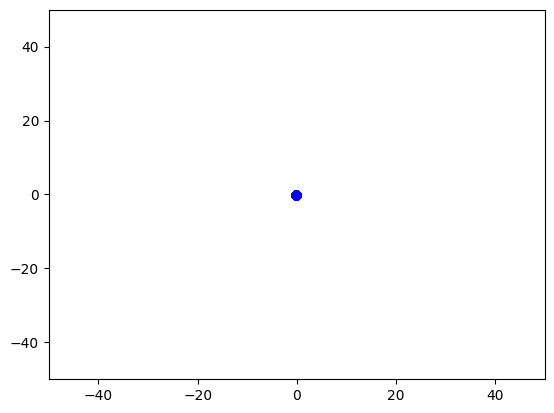

In [14]:
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-1*x_lim,x_lim))
plt.scatter(full_data_train[:,0],full_data_train[:,1],c="blue")
# full_data.max(),full_data.min()
# plt.hist(full_data_train[:,0],label='aa',bins=100)
# plt.hist(full_data_test[:,0],label='a',bins=100)



In [15]:
# xz.shape


(array([ 12.567203  ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.

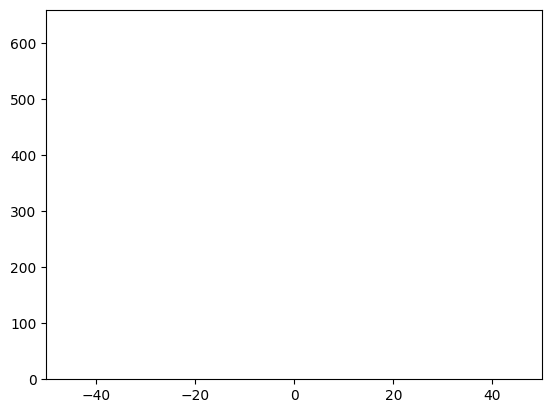

In [16]:
# # Generate some 2D data
# x=torch.tensor(full_data_train)
# x = ((full_data_train[:,:]-full_data_train.mean(0).unsqueeze(0)))/(full_data_train).std(0).unsqueeze(0)
# x=x.reshape(x.shape[0],2,5,2)
# print(x.shape)
# print(full_data_test.min(),full_data_test.max())
y = full_data_test[:,0]
plt.xlim((-1*x_lim,x_lim))

plt.hist(y,density=True,bins=1000)
# plt.hist(xz[:,0,2,1].reshape(xz.shape[0],-1),bins=100)



In [17]:
full_data_train.max(),full_data_test.max()

(33.485676, 32.655987)

## Building the  Model

In [18]:
dimension

412

In [19]:
if option_model=='simplemodel':
    print("simplemodel")
    # model=BigTimeConditionalNet(input_dim=dimension, time_dim=dimension, hidden_dim=hidden_dim).to(device)
    # model=MLP2(input_dim=dimension, time_dim=1, hidden_dim=hidden_dim).to(device) #PREVECTOR FIELD
    # model=MLP(input_dim=dimension, time_dim=1, hidden_dim=hidden_dim).to(device) #best of StudentT ,cone
    model=FullConnectedScoreModel(dimension,hidden_dim,n_hidden_layers).to(device)#best for pareto, copula
else:
    model = instantiate_model(
        architechture='studentT',
        is_discrete=False,
        use_ema=True,
    ).to(device)


if option=='simpletail':
    # Tail_paramNet=TimeToVecNet(1,hidden_dim,4*dimension).to(device)
    # Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*dimension).to(device) #LAMBDA +,- , MEAN , SCALE  #best of StudentT,Pareto
    # Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim//2,output_dim=4*dimension).to(device) #LAMBDA +,- , MEAN , SCALE   ,cone

    Tail_paramNet=MLP_TailParam2(time_dim=1, hidden_dim=hidden_dim,output_dim=4*dimension).to(device) #LAMBDA +,- , MEAN , SCALE # copula
    # Tail_paramNet=FullConnectedScoreModel_time(dimension,hidden_dim//2,n_hidden_layers//2).to(device)
    print("simple")
else:
    Tail_paramNet=instantiate_model(
    architechture=Dataset+'_tail',   #CHANGE MAYBE
    is_discrete=False,
    use_ema=True,
        ).to(device)
noise2data=TailAffineMarginalTransform_SeparateNetParam2(dimz=dimension).to(device)  


simplemodel
simple


In [20]:
# model(torch.randn(5,1,20),torch.randn(5),extra=[]).shape,Tail_paramNet(torch.randn(5,1,20),torch.randn(5),extra=[]).shape

In [21]:
# noise2data(torch.zeros(6,2),torch.zeros(6,8)).shape

In [22]:
lr = 0.0001

print_every = 10


In [23]:
train_dataset = TensorDataset(torch.tensor(full_data_train))


# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
jo=0 #counter
path = AffineProbPath(scheduler=CondOTScheduler())


optim = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=1e-3)
optim2=torch.optim.Adam(Tail_paramNet.parameters(), lr=lr,weight_decay=1e-3)#,weight_decay=1e-3)
loss_scaler = NativeScaler()
# scheduler = torch.optim.lr_scheduler.LinearLR(optim, start_factor=lr, end_factor=0.0, total_iters=iterations*len(train_loader))
# scheduler2 = torch.optim.lr_scheduler.LinearLR(optim2, start_factor=lr, end_factor=0.0, total_iters=iterations*len(train_loader))



c:\Users\adity\OneDrive\Desktop\mscThesis\Code3\Thesis_FLow\scaler_grad.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self._scaler = torch.cuda.amp.GradScaler()


In [25]:
dim=dimension
dimx=dimension

In [26]:
from typing import Callable
from torch import nn, Tensor

def jvp(f,x, v) -> tuple[Tensor, ...]:
    return torch.autograd.functional.jvp(
        f, x, v, 
        create_graph=torch.is_grad_enabled()
    )


def t_dir(f, t) -> tuple[Tensor, ...]:
    return jvp(f, t, torch.ones_like(t))


def get_t_dir(dimension,noise2data,Model, x: Tensor, t: Tensor) -> tuple[tuple[Tensor, Tensor], tuple[Tensor, Tensor]]:
    def flow(Xz,timez):
        # print("XZ_t",Xz.shape,timez.shape)
        param_tail_eps=Model(timez.unsqueeze(1))
        dummy_tail_param2=param_tail_eps.reshape(param_tail_eps.shape[0],4,dimension)
        _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = dummy_tail_param2[:,0,:],dummy_tail_param2[:,1,:],dummy_tail_param2[:,2,:],dummy_tail_param2[:,3,:]

        D1=noise2data.pos_tail(_unc_pos_tail2)
        D2=noise2data.neg_tail(_unc_neg_tail2)
        D3=shift2
        D4=noise2data.scale(_unc_scale2)   

        valuez=torch.cat([D1,D2,D3,D4],1)

        return(valuez)









    def f(x_in):
        def f_(t_in):
            return flow(x_in, t_in)
        return f_

    return t_dir(f(x), t)

In [27]:
class combined(nn.Module):
    def __init__(
        self,tail_param_net,PreVFnet,NOISE2DATA
    ):
        # self.features = features
        super(combined, self).__init__()
        self.tail_param_net=tail_param_net
        self.PreVFnet=PreVFnet
        self.NOISE2DATA=NOISE2DATA
    def forward(self, x_t,time_t):
        time_t=time_t.reshape(-1).expand(x_t.shape[0])
        lol=None

        if option_model=='simplemodel':
            prefinal_vf=self.PreVFnet(x_t,time_t)
        else:
            prefinal_vf=self.PreVFnet(x_t.unsqueeze(1),time_t,extra=[])
        prefinal_vf=prefinal_vf.reshape(prefinal_vf.shape[0],-1)
        if approach==2:        
        # print("x",x_t.shape,"timt=",time_t,time_t.shape,time_t.unsqueeze(1).shape)
            if option=='simpletail':
                param_tail=self.tail_param_net(time_t.unsqueeze(1)) #BX80

                True_timederiv=get_t_dir(dim,self.NOISE2DATA,self.tail_param_net,x_t,time_t)
                param_grad=True_timederiv[1] #time derive

            else:
                ones=torch.zeros(x_t.shape).to(device)+time_t.unsqueeze(1) #B X 20
                param_tail=self.tail_param_net(ones.unsqueeze(1),time_t,extra=[])  # B X 4 X 20 Generating Parameters of Tail net for each time step

            param_tail=param_tail.reshape(param_tail.shape[0],-1)
            param_tail_pre_eps=param_tail
            # print("param_tail",param_tail.shape)

            # print("LETSGO",x_t.shape,param_tail.shape)
            phi_t=self.NOISE2DATA.inverse(x_t,param_tail,False,None,None)

            jacobian_phi=self.NOISE2DATA.fwd_dTTF_dz(phi_t, param_tail)
            jacobian_param_tail=self.NOISE2DATA.dTTF_dtailparam(phi_t, param_tail)

            '''
            if option=='simpletail':
                param_tail_eps=self.tail_param_net(time_t.unsqueeze(1)+epsilon) 
            else:
                param_tail_eps=self.tail_param_net(ones.unsqueeze(1)+epsilon,time_t+epsilon,extra=[])
            
            param_tail_eps=param_tail_eps.reshape(param_tail_eps.shape[0],-1)
            

            dummy_tail_param=param_tail_pre_eps.reshape(param_tail_pre_eps.shape[0],4,dimension)
            _unc_pos_tail,_unc_neg_tail,shift,_unc_scale =dummy_tail_param[:,0,:],dummy_tail_param[:,1,:],dummy_tail_param[:,2,:],dummy_tail_param[:,3,:]

            # _unc_pos_tail,_unc_neg_tail,shift,_unc_scale, = param_tail_pre_eps[:,0:dimx],param_tail_pre_eps[:,dimx:2*dimx],param_tail_pre_eps[:,2*dimx:3*dimx],param_tail_pre_eps[:,3*dimx:4*dimx]
            # _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = param_tail_eps[:,0:dimx],param_tail_eps[:,dimx:2*dimx],param_tail_eps[:,2*dimx:3*dimx],param_tail_eps[:,3*dimx:4*dimx]


            dummy_tail_param2=param_tail_eps.reshape(param_tail_eps.shape[0],4,dimension)
            _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = dummy_tail_param2[:,0,:],dummy_tail_param2[:,1,:],dummy_tail_param2[:,2,:],dummy_tail_param2[:,3,:]


            
            
            D1=(self.NOISE2DATA.pos_tail(_unc_pos_tail2)-self.NOISE2DATA.pos_tail(_unc_pos_tail))/epsilon
            D2=(self.NOISE2DATA.neg_tail(_unc_neg_tail2)-self.NOISE2DATA.neg_tail(_unc_neg_tail))/epsilon
            D3=(shift2-shift)/epsilon
            D4=(self.NOISE2DATA.scale(_unc_scale2)-self.NOISE2DATA.scale(_unc_scale))/epsilon

            param_grad=torch.cat([D1,D2,D3,D4],1)
            '''
            # print("param_grad",param_grad.shape)
            # print("HOLA",jacobian_param_tail.shape,param_grad.shape)
            first_part=param_grad[:,0:dim]*jacobian_param_tail[0]+param_grad[:,dim:2*dim]*jacobian_param_tail[1]+param_grad[:,2*dim:3*dim]*jacobian_param_tail[2]+param_grad[:,3*dim:4*dim]*jacobian_param_tail[3]
            second_part=torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2)).squeeze(2)
            # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
            # print(first_part.shape,second_part.shape)
            velocity_field=first_part+second_part
        elif approach==1:
            velocity_field=prefinal_vf
        # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
        return(velocity_field)
        
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)



def calc_Wassertein(MODEL,TAIL_PARAMNET,NOISE2DATA,VAL_DATASET,dimension):
    # step size for ode solver
    Combo=combined(TAIL_PARAMNET,MODEL,NOISE2DATA)
    wrapped_vf = WrappedModel(Combo)
    step_size = 0.05

 

    batch_size = VAL_DATASET.shape[0]  # batch size
 
    T = torch.linspace(0,1,10)  # sample times
    T = T.to(device=device)
    # print(a)

    x_init = torch.randn((batch_size, dimension), dtype=torch.float32, device=device)
    solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
    sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model
    generated_data=sol[9].cpu().numpy()
    validation_data=VAL_DATASET
    distance=np.mean(plot_wasserstein_distances(generated_data,validation_data))
    print(generated_data.shape,validation_data.shape,distance,"aloha")

    return distance

    


import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance

def plot_wasserstein_distances(generate_data: np.ndarray, test_data: np.ndarray):
    """
    Computes and plots Wasserstein distances for each feature between generated and test data.

    Parameters:
    - generate_data: np.ndarray of shape (N, D)
    - test_data: np.ndarray of shape (N, D)
    """
    assert generate_data.shape[1] == test_data.shape[1], "Feature dimensions must match"
    num_features = generate_data.shape[1]
    
    distances = [
        wasserstein_distance(test_data[:, i], generate_data[:, i])
        for i in range(num_features)
    ]
    
    
    return distances  # Optional: return the distances for further use
 
    
   


In [28]:
print("NAME",name)

NAME weather


In [ ]:

# train
start_time = time.time()
min_loss=9999999999

for iI in range(iterations):
    loss_epoch=0
    for data in train_loader:
        optim.zero_grad()
        optim2.zero_grad()

        x_1=data[0].float().to(device)   #batch x 20
        x_0 = torch.randn_like(x_1).float().to(device) #batch x 20

        # print("x_shape",x_0.shape,x_1.shape,x_1.mean())

        if iI<(3*iterations)//4:
            t = 1-torch.sqrt(1-torch.rand(x_1.shape[0])).to(device) #best
        else:
            t= -torch.log(1 - torch.rand(x_1.shape[0]) * (1 - torch.exp(torch.tensor(-1)))).to(device)

        path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
        x_t,time_t,dx_t=path_sample.x_t,path_sample.t,path_sample.dx_t  #x_t- B X 20
        # print("x_t",x_t.shape)

        if option_model=='simplemodel':
            prefinal_vf=model(x_t,time_t)
        else:
            prefinal_vf=model(x_t.unsqueeze(1),time_t,extra=[])  #B X 1 X 20
        # print(prefinal_vf.shape)
        prefinal_vf=prefinal_vf.reshape(prefinal_vf.shape[0],-1) #B X 20
        # print("hello",prefinal_vf.shape)

        ones=torch.zeros(x_t.shape).to(device)+time_t.unsqueeze(1) #B X 20
        # print("ones",ones.shape,time_t.shape)

        if approach==2:
            if option=='simpletail':
                param_tail=Tail_paramNet(time_t.unsqueeze(1)) #BX80

                True_timederiv=get_t_dir(dim,noise2data,Tail_paramNet,x_t,time_t)
                param_grad=True_timederiv[1] #time derive
                # print("PARAM---",param_grad.min(),param_grad.max())
                # print(time_t.shape,True_timederiv[0].shape,True_timederiv[1].shape,param_tail.shape,param_grad.shape,"hallelja")
            else:
                param_tail=Tail_paramNet(ones.unsqueeze(1),time_t,extra=[])  # B X 4 X 20 Generating Parameters of Tail net for each time step

            print("param_tail",param_tail.shape,param_tail.max())
            param_tail=param_tail.reshape(param_tail.shape[0],-1)
            param_tail_pre_eps=param_tail


            phi_t=noise2data.inverse(x_t,param_tail,False,None,None)  #phi_t(x_0)  B X 20
            # print("phi_t",phi_t.shape,param_tail.shape) #BATCH X 2
            # print(a)

            

            jacobian_phi=noise2data.fwd_dTTF_dz(phi_t, param_tail) #B X 20 X 20
            # print("jac_phi",jacobian_phi.shape)
            jacobian_param_tail=(noise2data.dTTF_dtailparam(phi_t, param_tail)) #list of 4  ,BX20
            # print(jacobian_param_tail[0].shape,"JPT0")


            '''
            epsilon=1e-4
            if option=='simpletail':
                param_tail_eps=Tail_paramNet(time_t.unsqueeze(1)+epsilon) 
            else:
                param_tail_eps=Tail_paramNet(ones.unsqueeze(1)+epsilon,time_t+epsilon,extra=[])
            param_tail_eps=param_tail_eps.reshape(param_tail_eps.shape[0],-1)
            # print("param_tail_pre_eps and param_tail_ems",param_tail_pre_eps.shape,param_tail_eps.shape)

            dummy_tail_param=param_tail_pre_eps.reshape(param_tail_pre_eps.shape[0],4,dimension)
            _unc_pos_tail,_unc_neg_tail,shift,_unc_scale =dummy_tail_param[:,0,:],dummy_tail_param[:,1,:],dummy_tail_param[:,2,:],dummy_tail_param[:,3,:]
            '''


            # _unc_pos_tail,_unc_neg_tail,shift,_unc_scale, = param_tail_pre_eps[:,0:dimx],param_tail_pre_eps[:,dimx:2*dimx],param_tail_pre_eps[:,2*dimx:3*dimx],param_tail_pre_eps[:,3*dimx:4*dimx]
            # _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = param_tail_eps[:,0:dimx],param_tail_eps[:,dimx:2*dimx],param_tail_eps[:,2*dimx:3*dimx],param_tail_eps[:,3*dimx:4*dimx]

            '''
            dummy_tail_param2=param_tail_eps.reshape(param_tail_eps.shape[0],4,dimension)
            _unc_pos_tail2,_unc_neg_tail2,shift2,_unc_scale2, = dummy_tail_param2[:,0,:],dummy_tail_param2[:,1,:],dummy_tail_param2[:,2,:],dummy_tail_param2[:,3,:]

            D1=(noise2data.pos_tail(_unc_pos_tail2)-noise2data.pos_tail(_unc_pos_tail))/epsilon
            D2=(noise2data.neg_tail(_unc_neg_tail2)-noise2data.neg_tail(_unc_neg_tail))/epsilon
            D3=(shift2-shift)/epsilon
            D4=(noise2data.scale(_unc_scale2)-noise2data.scale(_unc_scale))/epsilon

            param_grad=torch.cat([D1,D2,D3,D4],1) 
            '''

            # print("Param_grad",param_grad.shape) #BX80
            first_part=param_grad[:,0:dim]*jacobian_param_tail[0]+param_grad[:,dim:2*dim]*jacobian_param_tail[1]+param_grad[:,2*dim:3*dim]*jacobian_param_tail[2]+param_grad[:,3*dim:4*dim]*jacobian_param_tail[3]
            second_part=torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2)).squeeze(2)
            # velocity_field=torch.bmm(jacobian_param_tail,param_grad)+torch.bmm(jacobian_phi,prefinal_vf.unsqueeze(2))
            # print(first_part.shape,second_part.shape)
            velocity_field=first_part+second_part
        else:
            velocity_field=prefinal_vf

        
        loss = torch.pow( velocity_field - dx_t, 2).mean()#/(0.001+torch.abs(dx_t.max()))# remove the max division for math correct
        
        print(velocity_field.max(),dx_t.max(),loss)

        loss_scaler(
            loss,
            optim,
            optim2,
            parameters=model.parameters(),
            parameters2=Tail_paramNet.parameters(),
            update_grad=True,
            approach=approach
            )      
        # scheduler.step()
        # scheduler2.step()

    # log loss
        jo=jo+1

        if (jo+1) % print_every == 0:
            elapsed = time.time() - start_time
            print('| iter {:6d} | {:5.2f} ms/step | loss {:8.3f} '
                .format(jo+1, elapsed*1000/print_every, loss.item()))
            start_time = time.time()
        if (jo)%50==0 and jo>(steps*0.9): 
            print("checking",iI)   

            loss_epoch=loss.item()#calc_Wassertein(model,Tail_paramNet,noise2data,full_data_val,dimension)
            if loss_epoch<min_loss:
                min_loss=loss_epoch
                print("saving iteration-",iI)
                torch.save(Tail_paramNet.state_dict(), 'tailmodel_NEW.pth')
                torch.save(model.state_dict(),"model_NEW.pth")
                model.train()
                Tail_paramNet.train()
    if jo+1>steps:
        break   

param_tail torch.Size([4096, 1648]) tensor(0.1712, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(143.7697, device='cuda:0', grad_fn=<MaxBackward1>) tensor(33.5125, device='cuda:0') tensor(2.7772, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
Tail_paramNet.load_state_dict(torch.load('tailmodel_NEW.pth'))
model.load_state_dict(torch.load("model_NEW.pth"))


<All keys matched successfully>

In [ ]:

torch.save(Tail_paramNet.state_dict(), name+'_'+str(approach)+'_tailmodel.pth')
torch.save(model.state_dict(),name+'_'+str(approach)+"_model.pth")


In [ ]:
print(min_loss)

0.6599032282829285


In [ ]:
model.eval()
Tail_paramNet.eval()

MLP_TailParam2(
  (main): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Swish()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): Swish()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): Swish()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Swish()
    (8): Linear(in_features=64, out_features=1648, bias=True)
  )
)

In [ ]:
Combo=combined(Tail_paramNet,model,noise2data)
# print(a)
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        return self.model(x, t)

# print(a)
wrapped_vf = WrappedModel(Combo)

In [ ]:
list(wrapped_vf.parameters())
a,b=torch.rand(1,dimension),torch.rand(1)
# print(z)
# Tail_paramNet(b.unsqueeze(1).to(device))
Combo(a.to(device),b.to(device))

tensor([[-1.1479e+00, -7.8234e-01, -1.5351e-01, -3.5237e-01, -5.6703e-01,
         -4.8880e-01, -4.7023e-01, -2.7078e-01, -3.1646e-01, -1.0337e+00,
         -6.0247e-01, -6.7916e-01, -2.3692e-01, -1.0136e+00, -2.6587e-01,
         -7.0311e-01, -2.6512e-01, -3.8984e-01, -2.6257e-01, -1.0600e+00,
         -3.6453e-01, -1.4513e-01, -2.6855e-02, -5.9591e-01, -6.8969e-01,
         -5.1006e-01, -3.1688e-01, -4.0516e-02, -6.1372e-01, -7.4833e-01,
         -6.4010e-02, -2.6854e-01, -1.8964e-01, -9.3374e-01,  2.5431e-02,
         -5.7325e-01, -1.5487e-01, -5.1234e-01, -8.4765e-01, -1.0761e+00,
         -1.1133e+00,  3.9132e-04, -6.7345e-01,  2.3689e-01, -3.5332e-01,
         -7.2564e-01, -5.0266e-01, -3.6118e-01, -4.0484e-01, -4.7919e-01,
         -7.3031e-01, -5.3206e-01, -1.0775e+00, -5.7499e-01, -6.2138e-02,
         -3.4015e-01, -2.1724e-01,  1.0719e-01,  3.7339e-01, -2.4630e-01,
         -3.6219e-02, -5.9823e-01, -2.9475e-01,  2.6880e-01,  7.2624e-02,
          2.4240e-01, -1.8329e-01, -7.

In [ ]:
# step size for ode solver
step_size = 0.05

norm = cm.colors.Normalize(vmax=50, vmin=0)

batch_size = full_data_test.shape[0]  # batch size
eps_time = 1e-2
T = torch.linspace(0,1,10)  # sample times
T = T.to(device=device)
# print(a)

x_init = torch.randn((batch_size, dimension), dtype=torch.float32, device=device)
solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model


In [ ]:
# print(sol)
# sol[0,:,0]=x_tst
x_tst=full_data_test


sol = sol.cpu().numpy()
T = T.cpu()


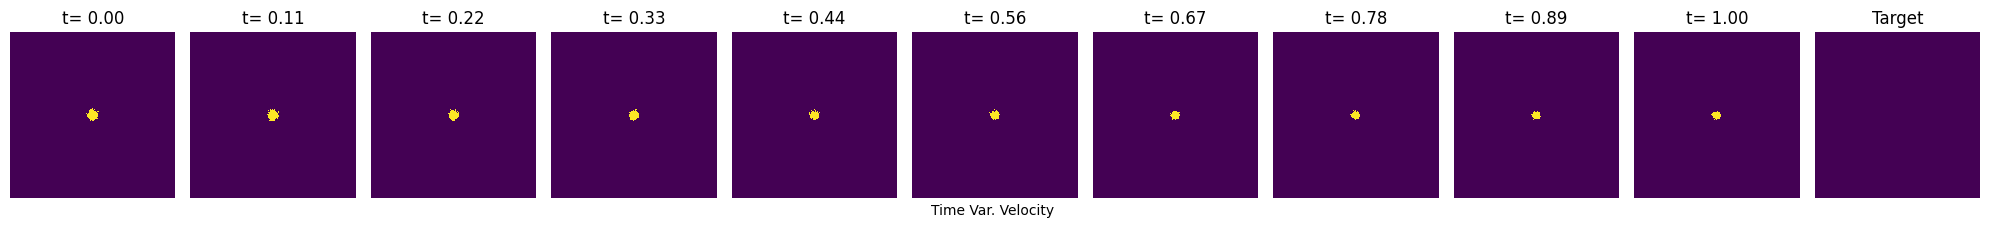

In [ ]:

RR=x_lim
fig, axs = plt.subplots(1, 11,figsize=(20,20))

for i in range(11):
    # if i==10:
    #     H = axs[i].hist2d(x_tst[:,0], x_tst[:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)
    # else:
    #     H= axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    cmin = 0.0
    cmax = 0.99#torch.quantile(torch.from_numpy(H[0]), 0.99).item()

    norm = cm.colors.Normalize(vmax=cmax, vmin=cmin)
    if i==10:
        _ = axs[i].hist2d(x_tst[:,0], x_tst[:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)
    else:
        _ = axs[i].hist2d(sol[i,:,0], sol[i,:,1], 300, range=((-1*RR,RR), (-1*RR,RR)), norm=norm)

    axs[i].set_aspect('equal')
    axs[i].axis('off')
    if i==10:
        axs[i].set_title('Target')
    else:

        axs[i].set_title('t= %.2f' % (T[i]))

plt.tight_layout()
fig.text(0.5, 0.45, 'Time Var. Velocity ', ha='center')
plt.show()

In [ ]:
full_data_test
generated_data=sol[9]

In [ ]:
# sample with likelihood

T = torch.tensor([1., 0.])  # sample times
T = T.to(device=device)

# grid_size = 200
# x_1 = torch.meshgrid(torch.linspace(-60, 60, grid_size), torch.linspace(-60, 60, grid_size))
# x_1 = torch.stack([x_1[0].flatten(), x_1[1].flatten()], dim=1).to(device)
x_1=torch.tensor(x_tst)[0:1000,:].to(device).float()
print(x_1.shape)

torch.Size([1000, 412])


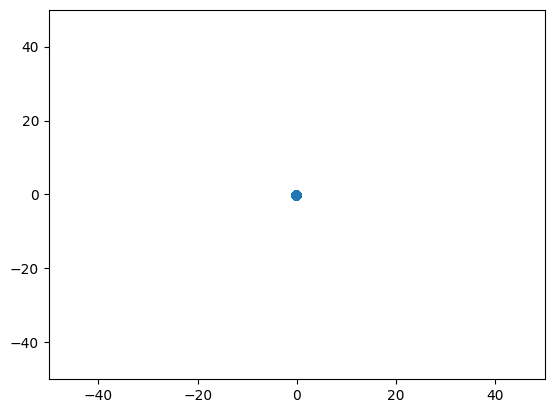

In [ ]:
plt.scatter(full_data_test[:,0],full_data_test[:,1])
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-x_lim,x_lim))
plt.show()

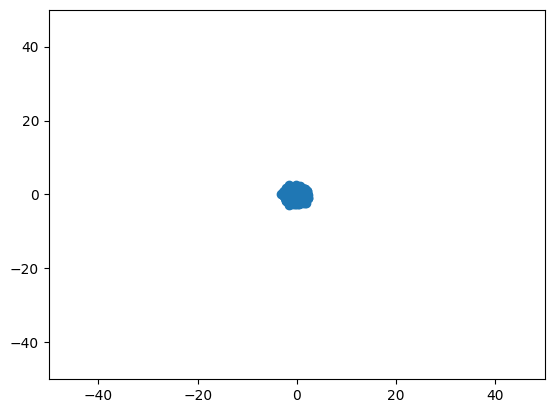

33.796883

In [ ]:
plt.scatter(generated_data[:,0],generated_data[:,1])
plt.ylim((-1*y_lim,y_lim))
plt.xlim((-x_lim,x_lim))
plt.show()
generated_data.max()

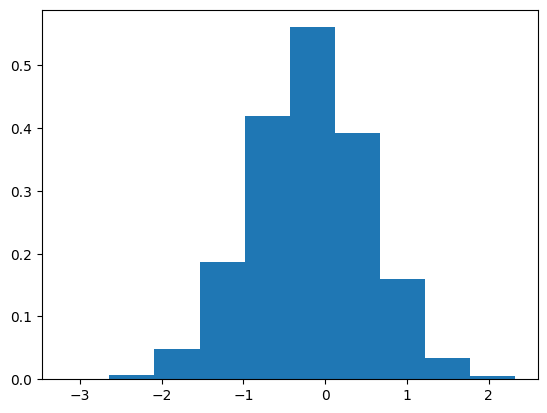

In [ ]:



plt.hist(generated_data[:,0],density=True,bins=10)
plt.show()

In [ ]:
full_data_test[:,0].min(),generated_data.min()

(-0.1398745, -4.862877)

In [ ]:
full_data_test.shape,generated_data.shape

((10000, 412), (10000, 412))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kde_subplots(test_data, gen_data, n_cols=3, figsize=(15, 4), suptitle=None):
    """
    Plots KDE comparisons between test and generated data for each dimension.

    Parameters:
    - test_data: np.ndarray of shape (batch, dim)
    - gen_data: np.ndarray of shape (batch, dim)
    - n_cols: Number of columns in subplot grid
    - figsize: Tuple (width, height) for each subplot row
    - suptitle: Optional super title for the figure
    """
    assert test_data.shape == gen_data.shape, "test_data and gen_data must have the same shape"
    
    batch, dim = test_data.shape
    n_rows = (dim + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1]*n_rows))
    axes = axes.flatten()

    for i in range(dim):
        ax = axes[i]
        sns.kdeplot(np.clip(test_data[:, i],-200,200), ax=ax, label='Test', color='blue')
        sns.kdeplot(np.clip(gen_data[:, i],-200,200), ax=ax, label='Generated', color='orange')
        ax.set_title(f'Dimension {i}')
        ax.legend()

    # Remove unused axes
    for j in range(dim, len(axes)):
        fig.delaxes(axes[j])

    if suptitle:
        plt.suptitle(suptitle, fontsize=16)
        plt.subplots_adjust(top=0.92)

    plt.tight_layout()
    plt.savefig(name+'_'+str(approach)+"kde_comparison.png", dpi=300, bbox_inches='tight')   

  
    plt.show()

plot_kde_subplots(full_data_test[0:generated_data.shape[0]],generated_data)

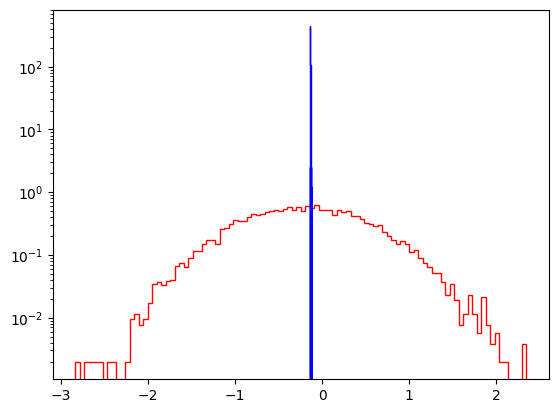

In [ ]:

# np.clip(full_data_test,-100,100)
plt.hist(generated_data[:,6],density=True,bins=100,color='red',histtype='step')
plt.hist(full_data_test[:,6],density=True,bins=100,color='blue',histtype='step')
ax = plt.gca()  # Get current Axes
ax.set_yscale('log')
# plt.xlim(-1*x_lim*2,x_lim*2)


In [ ]:
# source distribution is an isotropic gaussian
gaussian_log_density = Independent(Normal(torch.zeros(dimension, device=device), torch.ones(dimension, device=device)), 1).log_prob

# compute log likelihood with unbiased hutchinson estimator, average over num_acc
num_acc = 10
log_p_acc = 0

for i in range(num_acc):
    _, log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=False, log_p0=gaussian_log_density)
    log_p_acc += log_p
    print(log_p)

log_p_acc /= num_acc

# compute with exact divergence
# _, exact_log_p = solver.compute_likelihood(x_1=x_1, method='midpoint', step_size=step_size, exact_divergence=True, log_p0=gaussian_log_density)

tensor([-115.0728, -108.5722,  -91.0211,  -90.8984, -140.5489, -116.5379,
        -128.1235, -110.0232, -107.0526,  -89.7168,  -76.5816, -130.6037,
         -80.5948, -148.0108,  -92.2333, -128.7785,  -94.9324, -100.3744,
        -101.6924, -166.3830,  -56.3455,  -91.7158,  -96.4851,  -86.8970,
        -147.9417, -129.1495, -111.7578,  -96.3833, -113.4483,  -75.3343,
         -98.7616, -111.6386, -122.8683,  -80.5133,  -86.6725,  -85.3901,
         -96.3024,  -97.9720,  -77.1013,  -76.0423, -122.8684, -114.4080,
         -86.3604, -248.7543,  -70.1633, -122.3643,  -98.3837, -105.7451,
         -53.7734, -130.4276, -159.5074,  -64.3605,  -42.7610,  -85.7826,
         -69.8572,  -99.3231, -125.7427, -112.0591,  -98.0654, -106.3462,
        -125.3519, -114.6456, -121.6525,  -88.4675,  -98.3638,  -96.4272,
        -127.9654, -109.3772, -146.4383, -121.8870,  -97.5645, -123.6284,
        -111.4614, -133.1916, -132.5115,  -90.1580, -143.3090, -112.1850,
         -67.7015, -306.4783,  -94.804

In [ ]:
torch.sum(log_p_acc>log_p_acc.min()+10000)
mask=log_p_acc>log_p_acc.min()
zx=log_p_acc*mask 
zx.mean(),torch.sum(x_1>1000)

(tensor(-116.4123, device='cuda:0'), tensor(0, device='cuda:0'))

In [ ]:
print(log_p_acc.median(),log_p_acc.mean())  #    queueu=-14 pareto A117.81
#-3725 rms
# -99 rms
#-14 rms
#-63 adam
#-59.8   or(-45058.3555, d -693.8184, tensor(-50.9519, device='cuda:0') -36 best with decreaseing linear sampling tensor(0.2530, device='cuda:0') -6.1681

tensor(-105.9676, device='cuda:0') tensor(-116.8391, device='cuda:0')


In [ ]:
from extreme_transforms import softplus
TT = torch.linspace(0,1,10) 
softplus(Tail_paramNet(TT.unsqueeze(1).to(device))[:,16])

tensor([0.7266, 0.7269, 0.7273, 0.7277, 0.7282, 0.7287, 0.7292, 0.7298, 0.7305,
        0.7312], device='cuda:0', grad_fn=<SoftplusBackward0>)

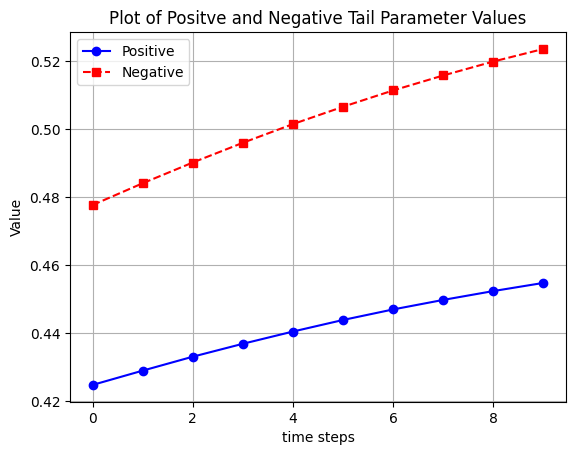

In [ ]:
import matplotlib.pyplot as plt

# Given data
data = [[0.4248, 0.4167, 0.4777, 0.4127],
        [0.4290, 0.4229, 0.4841, 0.4221],
        [0.4331, 0.4286, 0.4902, 0.4310],
        [0.4369, 0.4340, 0.4960, 0.4394],
        [0.4405, 0.4390, 0.5015, 0.4472],
        [0.4439, 0.4434, 0.5066, 0.4545],
        [0.4470, 0.4474, 0.5114, 0.4611],
        [0.4498, 0.4509, 0.5158, 0.4672],
        [0.4524, 0.4540, 0.5199, 0.4726],
        [0.4548, 0.4565, 0.5236, 0.4775]]

# Extract first and second columns
first_column = [row[0] for row in data]
second_column = [row[2] for row in data]

# Plot
plt.plot(first_column, marker='o', linestyle='-', color='b', label="Positive")
plt.plot(second_column, marker='s', linestyle='--', color='r', label="Negative")

# Labels and title
plt.xlabel("time steps")
plt.ylabel("Value")
plt.title("Plot of Positve and Negative Tail Parameter Values")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance




In [ ]:
# full_data_val.shape,full_data_train.shape,full_data_test.shape

In [ ]:
np.save(name+'_'+str(approach)+'_gen.npy', generated_data)
np.save(name+'_'+str(approach)+'_test.npy', full_data_test)

#saved datasets 
# _TTFgen_studentT_dof2,_TTFtest_studentT_dof2
# _vanillagen_studentT_dof2,_vanillatest_studentT_dof2


In [ ]:
import torch
from scipy import stats
def plot_wasserstein_distances(generate_data: np.ndarray, test_data: np.ndarray):
    """
    Computes and plots Wasserstein distances for each feature between generated and test data.

    Parameters:
    - generate_data: np.ndarray of shape (N, D)
    - test_data: np.ndarray of shape (N, D)
    """
    assert generate_data.shape[1] == test_data.shape[1], "Feature dimensions must match"
    num_features = generate_data.shape[1]
    
    distances = [
        wasserstein_distance(test_data[:, i], generate_data[:, i])
        for i in range(num_features)
    ]
    

    return distances  


def compute_kurtosis_ratio(
    generated_data: torch.Tensor, 
    test_data: torch.Tensor,
    eps: float = 1e-8
) -> torch.Tensor:

    generated_np = generated_data.flatten().cpu().numpy()
    test_data_np = test_data.flatten().cpu().numpy()


    k_sim = stats.kurtosis(generated_np, fisher=True, bias=True)
    k_data = stats.kurtosis(test_data_np, fisher=True, bias=True)
    print(k_sim,k_data)

    kr = abs(1 - (k_sim / (k_data + eps)))
    
    return torch.tensor(kr, dtype=torch.float32)

def compute_skewness_ratio(
    generated_data: torch.Tensor, 
    test_data: torch.Tensor,
    eps: float = 1e-8
) -> torch.Tensor:


    generated_np = generated_data.flatten().cpu().numpy()
    test_data_np = test_data.flatten().cpu().numpy()
    s_sim = stats.skew(generated_np, bias=True)
    s_data = stats.skew(test_data_np, bias=True)
    sr = abs(1 - (s_sim / (s_data + eps)))

    return torch.tensor(sr, dtype=torch.float32)

def compute_loglogarea(dimension,num_heavy,generated_data,test_data):
    area = []
    for j in range(dimension):
        print("D-",j)
        marginal_area = compute_arealoglog(test_data[:, j], generated_data[:, j])
        area.append(np.round(marginal_area, 5))

    
    area_heavy = np.mean(area[-num_heavy:])

    print(f"area_heavy {area_heavy}")
    if dimension!=num_heavy:
        area_light = np.mean(area[:-num_heavy])
        print(f"area_light {area_light}")


def compute_tvar(dimension,num_heavy,generated_data,test_data):
    tvar_dif = []
    num_samples=generated_data.shape[0]
    for component in range(dimension):
        sorted_abs_samps_synth = np.sort(np.abs(generated_data[:, component]))
        sorted_abs_data_test = np.sort(np.abs(test_data[:, component]))
        alpha = 0.95
        tvar_gen = 1 / (1 - alpha) * np.mean(sorted_abs_samps_synth[int(alpha * num_samples):])
        tvar_test = 1 / (1 - alpha) * np.mean(sorted_abs_data_test[int(alpha * len(sorted_abs_data_test)):])
        print(tvar_gen,tvar_test)
        tvar_dif.append(np.abs(tvar_test - tvar_gen))

    tvar_heavy = np.mean(tvar_dif[-num_heavy:])
    print(f"tvar_heavy {tvar_heavy}")
    if dimension!=num_heavy:
        tvar_light = np.mean(tvar_dif[:-num_heavy])
        print(f"tvar_light {tvar_light}")



In [ ]:
full_data_test.shape,generated_data.shape

((10000, 412), (10000, 412))

: 

In [ ]:
print("KURTOSIS RATIO-")
print(compute_kurtosis_ratio(torch.tensor(generated_data),torch.tensor(full_data_test)))
print("SKEWNESS RATIO")
print(compute_skewness_ratio(torch.tensor(generated_data),torch.tensor(full_data_test)))
print('loglogarea')
compute_loglogarea(dimension,num_heavy,torch.tensor(generated_data),torch.tensor(full_data_test))
print('tvar')
compute_tvar(dimension,num_heavy,torch.tensor(generated_data),torch.tensor(full_data_test))
print("wasserstein Distance")
wasdist_list=plot_wasserstein_distances(generated_data,torch.tensor(full_data_test))
print(wasdist_list)
print(np.mean(wasdist_list))    

KURTOSIS RATIO-
17.235847234600985 74.24590699286034
tensor(0.7679)
SKEWNESS RATIO
tensor(0.6703)
loglogarea
D- 0
D- 1
D- 2
D- 3
D- 4
D- 5
D- 6
D- 7
D- 8
D- 9
D- 10
D- 11
D- 12
D- 13
D- 14
D- 15
D- 16
D- 17
D- 18
D- 19
D- 20
D- 21


In [ ]:
num_heavy

4

In [ ]:
approach

1

In [ ]:
# #VANILLA STUDENT-T DOF2 
# KURTOSIS RATIO-
# -0.9886554413871314 -0.13172205151358396
# tensor(6.5056)
# SKEWNESS RATIO
# tensor(1.8856)
# loglogarea
# area_heavy 2.1910499999999997
# tvar
# 1136.4987182617178 1082.874755859374
# 1100.0538635253897 1084.6309661865225
# tvar_heavy 34.52342987060547
# wasserstein Distance
# [2.010277621612161, 1.091808276260133]
# 1.5510429489361472


In [ ]:
# #TTF STUDENT-T DOF2 
# KURTOSIS RATIO-
# -0.9462649229348492 -0.13172205151358396
# tensor(6.1838)
# SKEWNESS RATIO
# tensor(0.7570)
# loglogarea
# area_heavy 2.144705
# tvar
# 1158.4887695312489 1082.874755859374
# 1154.397735595702 1084.6309661865225
# tvar_heavy 72.69039154052712
# wasserstein Distance
# [1.8275462009884784, 2.1611849691267406]
# 1.9943655850576096



In [ ]:
# #vanilla funnel
# KURTOSIS RATIO-
# 196.0038329413005 887.7346459568462
# tensor(0.7792)
# SKEWNESS RATIO
# tensor(0.2768)
# loglogarea
# area_heavy 1.935435
# tvar
# 74.15870189666741 52.99304008483882
# 47.78810977935787 46.59492969512935
# tvar_heavy 11.179420948028554
# wasserstein Distance
# [0.0847870148361998, 0.043650976935035786]
# 0.06421899588561779

In [ ]:
#TTF funnel
# KURTOSIS RATIO-
# 459.8378724456536 887.7346459568462
# tensor(0.4820)
# SKEWNESS RATIO
# tensor(0.3806)
# loglogarea
# area_heavy 2.520035
# tvar
# 80.4613018035888 52.99304008483882
# 46.717500686645465 46.59492969512935
# tvar_heavy 13.795416355133046
# wasserstein Distance
# [0.10784876664010806, 0.028835785485832967]
# 0.06834227606297051

In [ ]:
# # # # #vanilla  copulla
# KURTOSIS RATIO-
# 54.99129211335096 2699.5573457953988
# tensor(0.9796)
# SKEWNESS RATIO
# tensor(0.9628)
# loglogarea
# area_heavy 2.3830600000000004
# area_light 0.47623
# tvar
# 45.80166339874263 46.82649569534424
# 44.956541061401325 46.77509469808694
# 39.01375055313107 40.10955513544897
# 40.22898674011227 42.15487962226853
# 52.97828197479243 55.77740157621871
# 46.74535751342769 54.860430291226386
# 34.965591430664034 39.97224794732626
# 48.00016880035396 47.634768990454944
# tvar_heavy 4.0715621764465535
# tvar_light 1.4662708494403471
# wasserstein Distance
# [0.01905762233524877, 0.03861360368446772, 0.033865190455384116, 0.05906165154397537, 0.04890639946042502, 0.04236680685665113, 0.021797414282590362, 0.04346517559377]
# 0.0383

In [ ]:
# # # #ttf copulla
#  KURTOSIS RATIO-
# 148.22257818002356 2699.5573457953988
# tensor(0.9451)
# SKEWNESS RATIO
# tensor(0.9171)
# loglogarea
# area_heavy 1.4965449999999998
# area_light 0.37497250000000004
# tvar
# 46.70217514038082 46.82649569534424
# 45.29917716979976 46.77509469808694
# 39.485495090484584 40.10955513544897
# 41.300778388977015 42.15487962226853
# 55.22737503051753 55.77740157621871
# 49.472393989562946 54.860430291226386
# 39.202363491058314 39.97224794732626
# 45.84247112274166 47.634768990454944
# tvar_heavy 2.125061292836463
# tvar_light 0.7695998403766264
# wasserstein Distance
# [0.01938728162438801, 0.016042521394373337, 0.03228027902050981, 0.03810216143800604, 0.04594755545707127, 0.02689968609464469, 0.03283537402521542, 0.0689957747409801]
# 0.035061329224398585

In [ ]:
approach

1